# Malware detection

A toy dataset for malware detection. It contains only two classes (benign and malware).

This notebook will address the topic of feature importance and feature selection.

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 7]

In [ ]:
df = pl.read_csv('../../datasets/malware_dataset.csv.gz')
df.head()

hash,millisecond,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""42fb5e2ec009a05ff5143227297074…",0,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a05ff5143227297074…",1,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a05ff5143227297074…",2,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a05ff5143227297074…",3,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
"""42fb5e2ec009a05ff5143227297074…",4,"""malware""",0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0


In [3]:
mapping = {'benign':0, 'malware':1}
df = df.with_columns(pl.col('classification').replace(mapping).cast(pl.Int32, strict=False).alias('classification'))

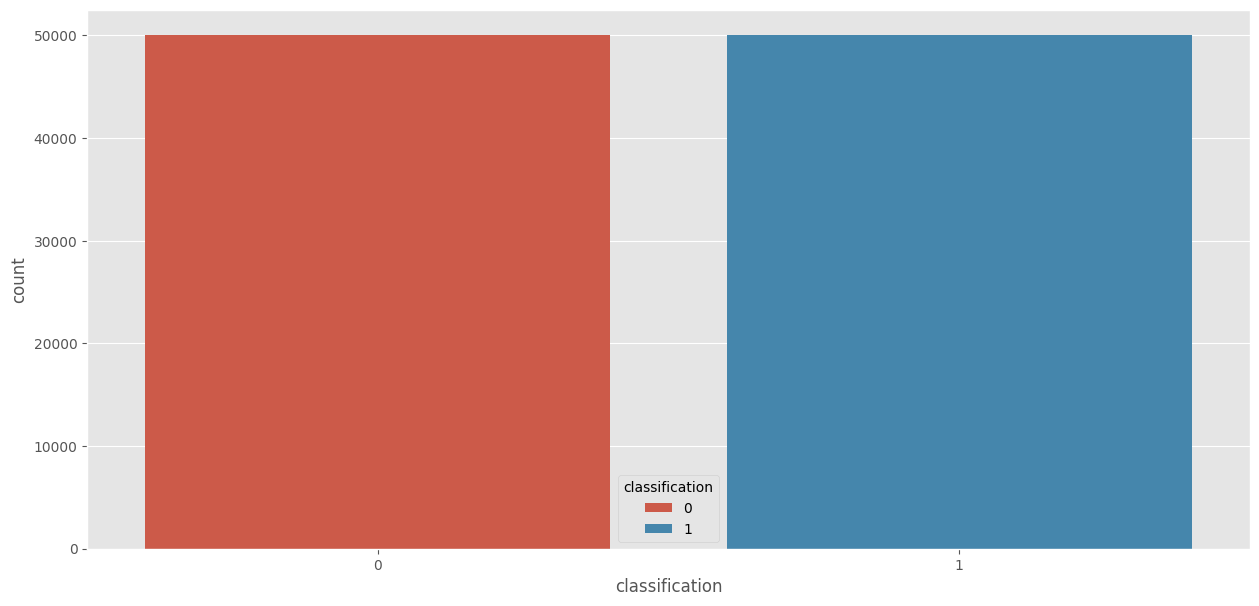

In [4]:
sns.countplot(data=df, x='classification', hue='classification')
plt.show()

In [5]:
df = df.drop(['hash', 'millisecond'])
df.describe()

statistic,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.5,157768.33536,0.0,3.0697e9,18183.90007,0.0,0.0,0.0,15312.73951,0.0,0.0,9.58777,728.46543,8771.13948,0.0,266.49112,117.92024,127.67815,205.32485,0.0,117.92024,2435.97361,348313.0716,32.99116,2.05313,117.92024,1.10919,3.2044e9,385415.45197,4.05931,1.66142,0.0,0.0
"""std""",0.500003,936172.583333,0.0,296306.144182,4609.792765,0.0,0.0,0.0,3256.475008,0.0,0.0,46.504908,84.475361,3785.30516,0.0,311.996779,3.116892,22.277995,112.717875,0.0,3.116892,2605.564669,9117.720632,52.730176,13.881382,3.116892,2.160466,0.0,10144.036494,0.822848,3.26304,0.0,0.0
"""min""",0.0,0.0,0.0,3.0692e9,13988.0,0.0,0.0,0.0,9695.0,0.0,0.0,0.0,612.0,2588.0,0.0,4.0,112.0,92.0,29.0,0.0,112.0,0.0,337688.0,0.0,0.0,112.0,0.0,3.2044e9,371782.0,3.0,0.0,0.0,0.0
"""25%""",0.0,0.0,0.0,3.0695e9,14352.0,0.0,0.0,0.0,12648.0,0.0,0.0,0.0,651.0,6428.0,0.0,99.0,114.0,112.0,112.0,0.0,114.0,0.0,341974.0,1.0,0.0,114.0,0.0,3.2044e9,378208.0,3.0,0.0,0.0,0.0
"""50%""",1.0,0.0,0.0,3.0697e9,16159.0,0.0,0.0,0.0,15245.0,0.0,0.0,1.0,725.0,7865.0,0.0,177.0,120.0,127.0,193.0,0.0,120.0,2017.0,347244.0,9.0,1.0,120.0,0.0,3.2044e9,383637.0,4.0,0.0,0.0,0.0
"""75%""",1.0,4096.0,0.0,3.0700e9,22182.0,0.0,0.0,0.0,17663.0,0.0,0.0,4.0,785.0,10684.0,0.0,327.0,120.0,138.0,273.0,0.0,120.0,4036.0,351667.0,46.0,1.0,120.0,1.0,3.2044e9,390324.0,5.0,1.0,0.0,0.0
"""max""",1.0,4.3266048e7,0.0,3.0702e9,31855.0,0.0,0.0,0.0,27157.0,0.0,0.0,515.0,995.0,28184.0,0.0,2810.0,120.0,196.0,755.0,0.0,120.0,9526.0,384520.0,365.0,256.0,120.0,18.0,3.2044e9,421913.0,7.0,15.0,0.0,0.0


## Drop columns with low variance

In [6]:
threshold = 0.5
df = df.drop([col.name for col in df.select(pl.all().std() < threshold) if col.item()])
df.describe()

statistic,classification,state,prio,static_prio,vm_truncate_count,free_area_cache,mm_users,map_count,total_vm,shared_vm,exec_vm,reserved_vm,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,utime,stime,gtime
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.5,157768.33536,3.0697e9,18183.90007,15312.73951,9.58777,728.46543,8771.13948,266.49112,117.92024,127.67815,205.32485,117.92024,2435.97361,348313.0716,32.99116,2.05313,117.92024,1.10919,385415.45197,4.05931,1.66142
"""std""",0.500003,936172.583333,296306.144182,4609.792765,3256.475008,46.504908,84.475361,3785.30516,311.996779,3.116892,22.277995,112.717875,3.116892,2605.564669,9117.720632,52.730176,13.881382,3.116892,2.160466,10144.036494,0.822848,3.26304
"""min""",0.0,0.0,3.0692e9,13988.0,9695.0,0.0,612.0,2588.0,4.0,112.0,92.0,29.0,112.0,0.0,337688.0,0.0,0.0,112.0,0.0,371782.0,3.0,0.0
"""25%""",0.0,0.0,3.0695e9,14352.0,12648.0,0.0,651.0,6428.0,99.0,114.0,112.0,112.0,114.0,0.0,341974.0,1.0,0.0,114.0,0.0,378208.0,3.0,0.0
"""50%""",1.0,0.0,3.0697e9,16159.0,15245.0,1.0,725.0,7865.0,177.0,120.0,127.0,193.0,120.0,2017.0,347244.0,9.0,1.0,120.0,0.0,383637.0,4.0,0.0
"""75%""",1.0,4096.0,3.0700e9,22182.0,17663.0,4.0,785.0,10684.0,327.0,120.0,138.0,273.0,120.0,4036.0,351667.0,46.0,1.0,120.0,1.0,390324.0,5.0,1.0
"""max""",1.0,4.3266048e7,3.0702e9,31855.0,27157.0,515.0,995.0,28184.0,2810.0,120.0,196.0,755.0,120.0,9526.0,384520.0,365.0,256.0,120.0,18.0,421913.0,7.0,15.0


## Split the data

In [7]:
Y = df['classification']
X = df.drop(['classification'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Logistic Regression Feature Importance

We can fit a LogisticRegression model on the regression dataset and retrieve the coeff_ property that contains the coefficients found for each input variable.

These coefficients can provide the basis for a crude feature importance score. This assumes that the input variables have the same scale or have been scaled prior to fitting a model.

The complete example of logistic regression coefficients for feature importance is listed below.

              precision    recall  f1-score   support

      Benign       0.96      0.92      0.94     10030
     Malware       0.92      0.96      0.94      9970

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Feature: 0, Score: 0.05136
Feature: 1, Score: -0.34836
Feature: 2, Score: 2.45199
Feature: 3, Score: 0.22657
Feature: 4, Score: 0.42878
Feature: 5, Score: 5.31146
Feature: 6, Score: 1.19825
Feature: 7, Score: -1.04398
Feature: 8, Score: -1.89564
Feature: 9, Score: 5.63520
Feature: 10, Score: -1.17985
Feature: 11, Score: -1.89564
Feature: 12, Score: 5.07465
Feature: 13, Score: -8.28506
Feature: 14, Score: -1.43367
Feature: 15, Score: -0.03926
Feature: 16, Score: -1.89564
Feature: 17, Score: 0.78091
Feature: 18, Score: -14.65332
Feature: 19, Score: -0.35455
Feature: 20, Score: -1.79791


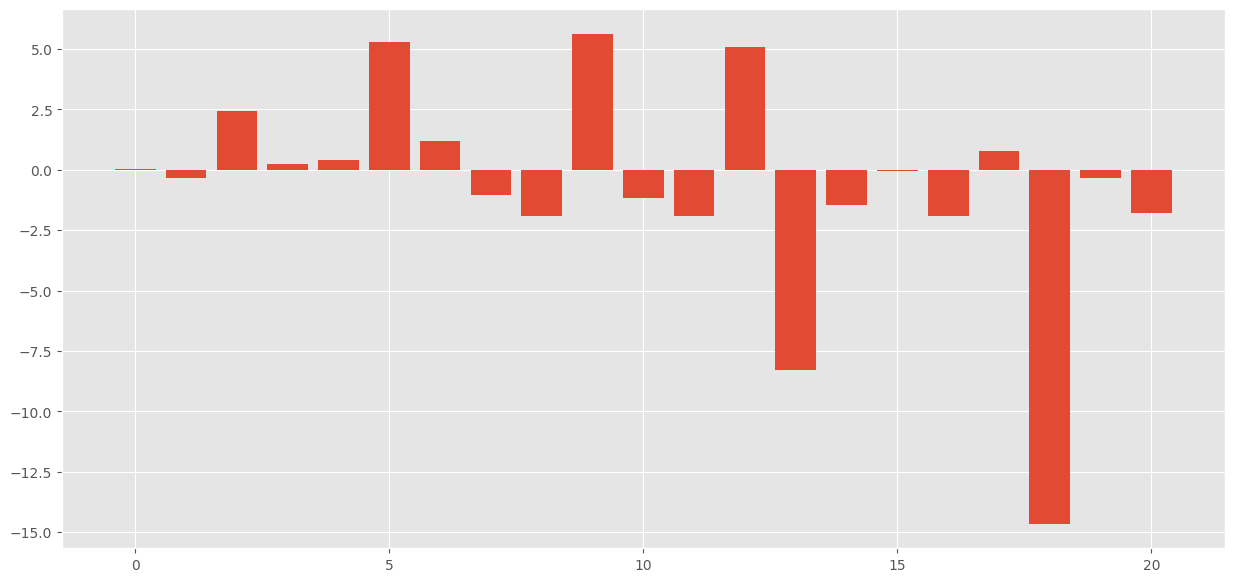

In [9]:
from sklearn.linear_model import LogisticRegression

# define the model
model = LogisticRegression(max_iter=1000)
# fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Decision Tree Feature Importance

Decision tree algorithms like classification and regression trees (CART) offer importance scores based on the reduction in the criterion used to select split points, like Gini or entropy.

This same approach can be used for ensembles of decision trees, such as the random forest and stochastic gradient boosting algorithms.

Let’s take a look at a worked example of each.

### CART Feature Importance

We can use the CART algorithm for feature importance implemented in scikit-learn as the DecisionTreeRegressor and DecisionTreeClassifier classes.

After being fit, the model provides a feature_importances_ property that can be accessed to retrieve the relative importance scores for each input feature.

Let’s take a look at an example of this for regression and classification.

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     10030
     Malware       1.00      1.00      1.00      9970

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.01548
Feature: 2, Score: 0.53893
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00466
Feature: 6, Score: 0.00715
Feature: 7, Score: 0.04011
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.05595
Feature: 10, Score: 0.03340
Feature: 11, Score: 0.19836
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.06438
Feature: 14, Score: 0.00558
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00123
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.02166
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.01309


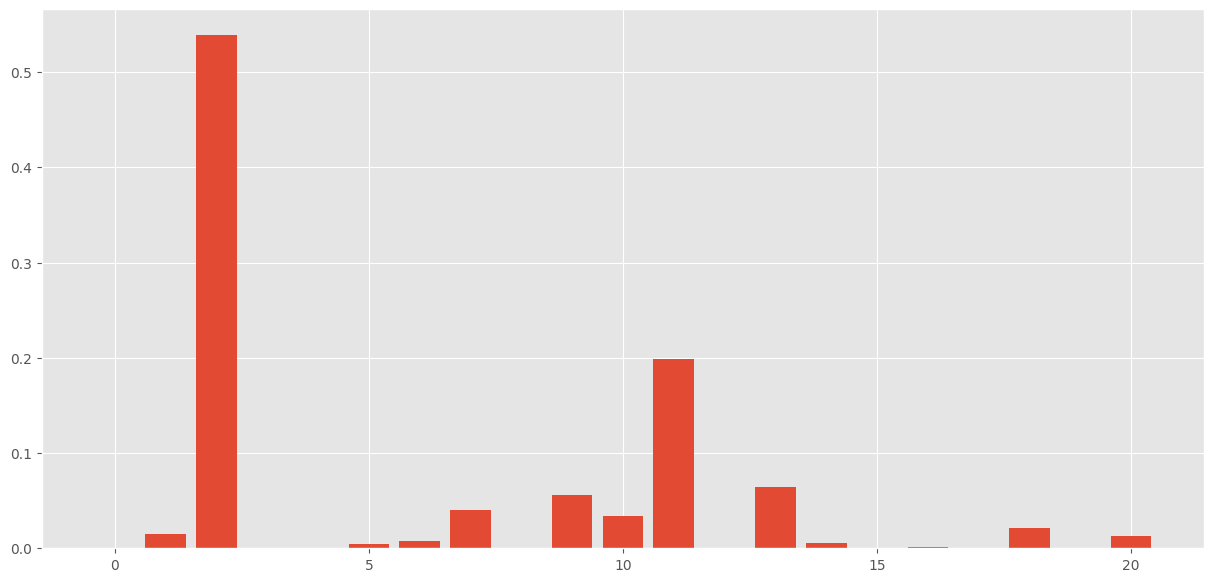

In [10]:
from sklearn.tree import DecisionTreeClassifier

# define the model
model = DecisionTreeClassifier()

# fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Random Forest Feature Importance

We can use the Random Forest algorithm for feature importance implemented in scikit-learn as the RandomForestRegressor and RandomForestClassifier classes.

After being fit, the model provides a feature_importances_ property that can be accessed to retrieve the relative importance scores for each input feature.

This approach can also be used with the bagging and extra trees algorithms.

Let’s take a look at an example of this for regression and classification.

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     10030
     Malware       1.00      1.00      1.00      9970

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Feature: 0, Score: 0.00093
Feature: 1, Score: 0.02783
Feature: 2, Score: 0.24449
Feature: 3, Score: 0.04720
Feature: 4, Score: 0.12130
Feature: 5, Score: 0.03083
Feature: 6, Score: 0.03621
Feature: 7, Score: 0.02239
Feature: 8, Score: 0.04214
Feature: 9, Score: 0.04050
Feature: 10, Score: 0.02637
Feature: 11, Score: 0.04346
Feature: 12, Score: 0.02637
Feature: 13, Score: 0.09824
Feature: 14, Score: 0.01999
Feature: 15, Score: 0.00075
Feature: 16, Score: 0.04454
Feature: 17, Score: 0.01082
Feature: 18, Score: 0.09315
Feature: 19, Score: 0.01328
Feature: 20, Score: 0.00920


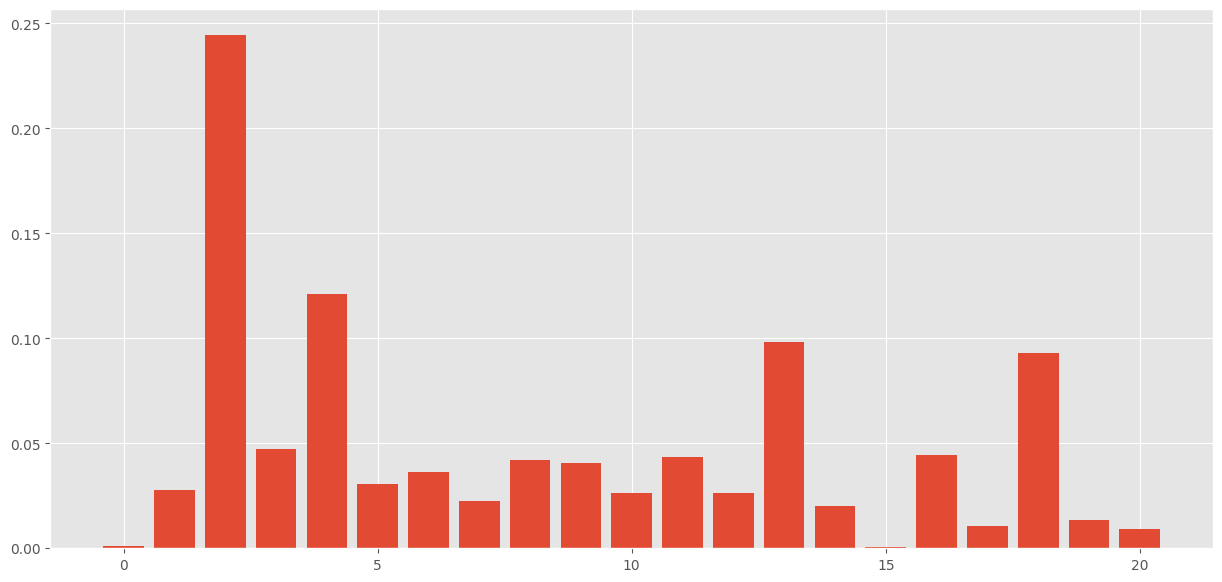

In [11]:
from sklearn.ensemble import RandomForestClassifier

# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Permutation Feature Importance

Permutation feature importance is a technique for calculating relative importance scores that is independent of the model used.

First, a model is fit on the dataset, such as a model that does not support native feature importance scores. Then the model is used to make predictions on a dataset, although the values of a feature (column) in the dataset are scrambled. This is repeated for each feature in the dataset. Then this whole process is repeated 3, 5, 10 or more times. The result is a mean importance score for each input feature (and distribution of scores given the repeats).

This approach can be used for regression or classification and requires that a performance metric be chosen as the basis of the importance score, such as the mean squared error for regression and accuracy for classification.

Permutation feature selection can be used via the permutation_importance() function that takes a fit model, a dataset (train or test dataset is fine), and a scoring function.

Let’s take a look at this approach to feature selection with an algorithm that does not support feature selection natively, specifically k-nearest neighbors.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# define the model
model = KNeighborsClassifier()

# fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

# perform permutation importance
results = permutation_importance(model, X_train, y_train, scoring='accuracy')

# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     10030
     Malware       1.00      1.00      1.00      9970

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

